In [225]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import random
import time

## **Class implementation**

In [ ]:
def fitness_backpack(individual: np.ndarray, weights: np.ndarray, values: np.ndarray, max_weight: int) -> int: 
    if max_weight - np.sum(weights[individual==1]) < 0:
        fitness = 0
    else:
        fitness = np.sum(values[individual==1])
    return fitness

In [236]:
class AG_Mochila():
    def __init__(self, population_size: int, weights: list[int], values: list[int], max_weight: int):
        """Create the population"""

        self.population = np.zeros(shape=(population_size, len(weights)), dtype=int)
        self.fitnesses  = np.zeros(shape=(population_size), dtype=int)
        self.weights = np.asarray(weights)
        self.values  = np.asarray(values)
        self.max_weight = max_weight

        ind_length = len(self.weights)

        for i in range(population_size):
            indexes = random.sample(range(ind_length), random.randint(1, ind_length))
            individual = np.zeros_like(self.weights, dtype=int)
            individual[indexes] = 1
            self.population[i] = individual
        
    def sort_pop(self, fitness_function, reverse_sort: bool) -> None:
        """Sort population by fitness function. Return tuple with population list and fitness list"""

        fitness_list = np.array([fitness_function(ind, self.weights, self.values, self.max_weight) for ind in self.population])
        sorted_indices = np.argsort(fitness_list)[::-1] if reverse_sort else np.argsort(fitness_list)
        # Reordenar la población y fitness según los índices ordenados
        self.population = self.population[sorted_indices]
        self.fitnesses = fitness_list[sorted_indices]

    def select(self, T: int) -> np.ndarray:
        """Return a copy of an indivudual by tournament selection. Population already ordered by fitness"""

        choices=np.random.choice(len(self.population), size=T, replace=False)
        return self.population[np.min(choices)]
    
    def crossover(self, parent1: np.ndarray, parent2: np.ndarray, pcross: float) -> tuple[np.ndarray, np.ndarray]:
        """Performs PMX crossover on two parents to generate two children."""
        
        child1 = np.copy(parent1)
        child2 = np.copy(parent2)

        if random.random() < pcross:
            size = len(parent1)
            start, end = sorted(random.sample(range(size), 2))

            # cruzar segmento intermedio
            child1[start:end+1] = parent2[start:end+1]
            child2[start:end+1] = parent1[start:end+1]

        return child1, child2

    def mutate(self, individual: np.ndarray, pmut: float) -> np.ndarray:
        """Mutate an individual, swap elements. Return mutated individual"""
    
        def mutate_swap(individual: np.ndarray, pmut: float) -> np.ndarray:
            if random.random() < pmut:
                index1, index2 = random.choices(range(len(individual)), k=2)
                temp = individual[index1]
                individual[index1] = individual[index2]
                individual[index2] = temp
            return individual

        def mutate_insert(individual: np.ndarray, pmut: float) -> np.ndarray:
            if random.random() < pmut:
                index_pop, index_insert = random.choices(range(len(individual)), k=2)
                pop_value = individual[index_pop]
                individual = np.delete(individual, index_pop)
                individual = np.insert(individual, index_insert, pop_value)
            return individual

        def mutate_reverse(individual: np.ndarray, pmut: float) -> np.ndarray: 
            if random.random() < pmut:
                index1, index2 = sorted(random.sample(range(len(individual)), 2))
                individual[index1:index2 + 1] = individual[index1:index2 + 1][::-1]
            return individual
        
        mutations = [mutate_swap, mutate_insert, mutate_reverse]
        mutations = [mutate_swap, mutate_insert]
        operator = random.choice(mutations)
        return operator(individual, pmut)

    def evolve(self, fitness_function, pmut=0.1, pcross=0.7, ngen=100, T=2, trace=50, reverse_sort=False, elitism=False) -> None:
        """Evolution procedure. Initial population already created"""

        for i in range(ngen):
            new_pop = np.empty((0,self.weights.shape[0]), dtype=int)
            self.sort_pop(fitness_function, reverse_sort)
            if elitism:
                new_pop = np.vstack([new_pop, self.population[0], self.population[1]])
            while new_pop.shape[0] != self.population.shape[0]:   
                individual1 = self.select(T)
                individual2 = self.select(T)
                child1, child2 = self.crossover(individual1, individual2, pcross)
                mutated1 = self.mutate(child1, pmut)
                mutated2 = self.mutate(child2, pmut)
                new_pop = np.vstack([new_pop, mutated1, mutated2])
                
            self.population = np.array([*new_pop])

            if i % trace == 0 or i == ngen-1: # en la última gen se ordena
                self.sort_pop(fitness_function, reverse_sort)
                print(f"Nº gen: {i}, Best ind: {self.population[0]}, Best fitness: {self.fitnesses[0]}")

## **Visual test**

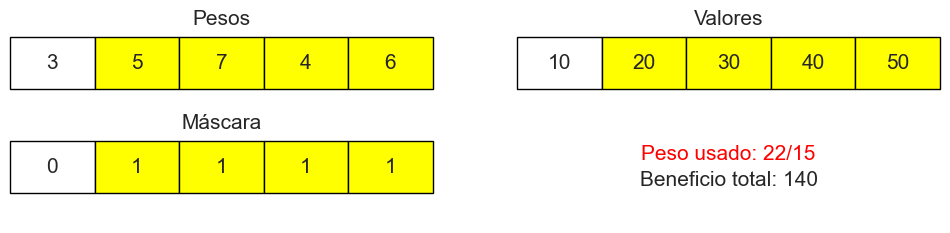

In [ ]:
def plot_backpack(individual: np.ndarray, weights: list[int], values: list[int], max_weight: int):
    weights = np.asarray(weights) 
    values = np.asarray(values)  

    used_weight = np.sum(weights * individual)
    total_value = np.sum(values * individual)

    def plot_grid(ax: Axes, data: np.ndarray, title: str):
        ax.set_title(title, fontsize=15, ha='center')
        ax.axis('off')
        
        table = ax.table(cellText=[data], cellLoc='center', loc='center', bbox=[0, 0.35, 1, 0.6])
        table.set_fontsize(15)
        table.scale(1, 1)

        for i, val in enumerate(individual):
                if val == 1:  # valor de máscara con 1
                    table[(0, i)].set_facecolor("yellow")
        
    fig, axs = plt.subplots(2, 2, figsize=(12, 5))

    plot_grid(axs[0, 0], weights, "Pesos")   
    plot_grid(axs[0, 1], values, "Valores")  
    plot_grid(axs[1, 0], individual, "Máscara") 

    # cuarto gráfico
    color = "green" if used_weight <= max_weight else "red"
    axs[1, 1].axis("off")
    axs[1, 1].text(0.5, 0.8, f"Peso usado: {used_weight}/{max_weight}", fontsize=15, ha='center', va='center', color=color)
    axs[1, 1].text(0.5, 0.5, f"Beneficio total: {total_value}", fontsize=15, ha='center', va='center')

    plt.subplots_adjust(bottom=0.5)
    plt.show()
# -----------------------
weights = [3, 5, 7, 4, 6]
values = [10, 20, 30, 40, 50]
max_weight = 15
ind = np.array([0,1,1,1,1])
plot_backpack(ind, weights, values, max_weight)

## **---------------------------Tests---------------------------**

Nº gen: 0, Best ind: [1 0 0 1 1], Best fitness: 100
Nº gen: 20, Best ind: [0 1 0 1 1], Best fitness: 110
Nº gen: 40, Best ind: [0 1 0 1 1], Best fitness: 110
Nº gen: 60, Best ind: [0 1 0 1 1], Best fitness: 110
Nº gen: 80, Best ind: [0 1 0 1 1], Best fitness: 110
Nº gen: 99, Best ind: [0 1 0 1 1], Best fitness: 110
*******Tiempo evolución: 0 minutos y 0.02 segundos*******


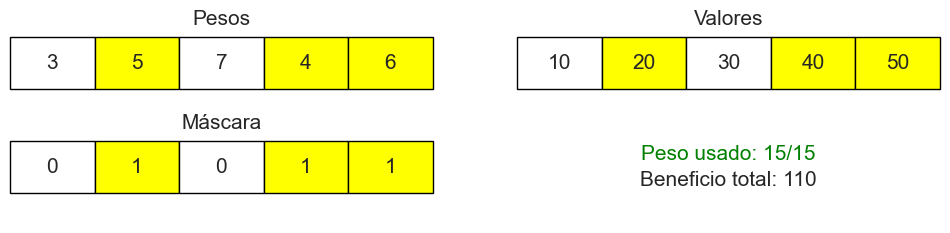

In [247]:
weights = [3, 5, 7, 4, 6]
values = [10, 20, 30, 40, 50]
max_weight = 15
genetic_algorithm = AG_Mochila(population_size=6, weights=weights, values=values, max_weight=max_weight)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_backpack, pmut=0.1, ngen=100, T=3, trace=20, reverse_sort=True)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

plot_backpack(genetic_algorithm.population[0], weights, values, max_weight)

Nº gen: 0, Best ind: [1 1 0 0 1 0 1 0 0 1], Best fitness: 170
Nº gen: 20, Best ind: [0 0 0 1 0 0 1 1 1 1], Best fitness: 210
Nº gen: 40, Best ind: [0 0 0 1 0 0 1 1 1 1], Best fitness: 210
Nº gen: 60, Best ind: [0 0 0 1 0 0 1 1 1 1], Best fitness: 210
Nº gen: 80, Best ind: [0 0 0 1 0 0 1 1 1 1], Best fitness: 210
Nº gen: 99, Best ind: [0 0 0 1 0 0 1 1 1 1], Best fitness: 210
*******Tiempo evolución: 0 minutos y 0.13 segundos*******


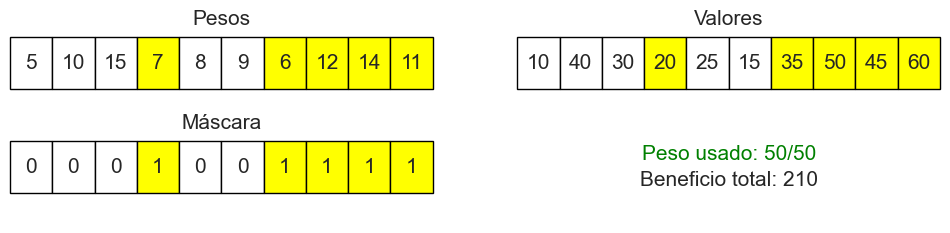

In [231]:
weights = [5, 10, 15, 7, 8, 9, 6, 12, 14, 11]
values = [10, 40, 30, 20, 25, 15, 35, 50, 45, 60]
max_weight = 50

genetic_algorithm = AG_Mochila(population_size=50, weights=weights, values=values, max_weight=max_weight)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_backpack, pmut=0.1, ngen=100, T=3, trace=20, reverse_sort=True)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

plot_backpack(genetic_algorithm.population[0], weights, values, max_weight)

Nº gen: 0, Best ind: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1], Best fitness: 270
Nº gen: 20, Best ind: [1 1 0 0 1 1 0 0 0 0 0 0 0 0 0], Best fitness: 370
Nº gen: 40, Best ind: [1 1 0 0 1 1 0 0 0 0 0 0 0 0 0], Best fitness: 370
Nº gen: 60, Best ind: [1 1 0 0 1 1 0 0 0 0 0 0 0 0 0], Best fitness: 370
Nº gen: 80, Best ind: [1 1 0 0 1 1 0 0 0 0 0 0 0 0 0], Best fitness: 370
Nº gen: 99, Best ind: [1 1 0 0 1 1 0 0 0 0 0 0 0 0 0], Best fitness: 370
*******Tiempo evolución: 0 minutos y 0.23 segundos*******


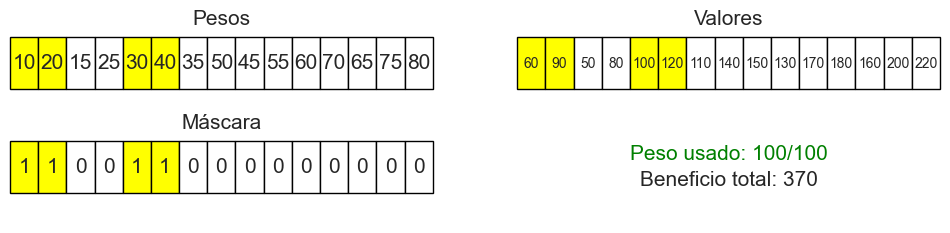

In [232]:
weights = [10, 20, 15, 25, 30, 40, 35, 50, 45, 55, 60, 70, 65, 75, 80]
values = [60, 90, 50, 80, 100, 120, 110, 140, 150, 130, 170, 180, 160, 200, 220]
max_weight = 100

genetic_algorithm = AG_Mochila(population_size=100, weights=weights, values=values, max_weight=max_weight)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_backpack, pmut=0.1, ngen=100, T=3, trace=20, reverse_sort=True)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

plot_backpack(genetic_algorithm.population[0], weights, values, max_weight)